Train and score a boosted decision tree model using [LightGBM Python package](https://github.com/Microsoft/LightGBM) from Microsoft, which is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms.  

In [1]:
import os
import sys
import math
import itertools
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb 

In [2]:
# Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(os.path.dirname(nb_dir)))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

from common.metrics import MAPE
import retail_sales.OrangeJuice_Pt_3Weeks_Weekly.common.benchmark_settings as bs

In [39]:
# Data paths
DATA_DIR = '../../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Parameters of GBM model
params = {
    'num_leaves': 50, 
    'objective': 'mape', 
    'min_data_in_leaf': 200, 
    'learning_rate': 0.002, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'num_threads': 16
}
MAX_ROUNDS = 400 #100 

# Lags and categorical features
lags = [2,3,4] 
lags_str = [str(x) for x in lags]
categ_fea = ['store', 'brand', 'deal', 'feat'] 

first_week_start = pd.to_datetime('1989-09-07 00:00:00') 

In [40]:
# Utility functions
def week_of_month(dt):
    """ 
    Get the week of the month for the specified date.
    
    Args: 
        dt (Datetime): Input date
        
    Returns:
        wom (Integer): Week of the month of the input date
    """ 
    from math import ceil
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    wom = int(ceil(adjusted_dom/7.0))
    return wom

def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product
    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df

def lagged_features(df, lags):
    """Create lagged features based on time series data.
    
    Args:
        df (Dataframe): Input time series data sorted by time
        lags (List): Lag lengths
        
    Returns:
        fea (Dataframe): Lagged features 
    """
    df_list = []
    for lag in lags:
        df_shifted = df.shift(lag)
        df_shifted.columns = [x + '_lag' + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    fea = pd.concat(df_list, axis=1)
    return fea

def moving_averages(df, start_step, window_size=None):
    """
    Compute averages of every feature over moving time windows.
    
    Args:
        df (Dataframe): Input features as a dataframe
    
    Returns:
        fea (Dataframe): Dataframe consisting of the moving averages
    """
    if window_size == None: # Use a large window to compute average over all historical data
        window_size = df.shape[0]
    fea = df.shift(start_step).rolling(min_periods=1, center=False, window=window_size).mean()
    fea.columns = fea.columns + '_mean'
    return fea

def create_features(df):
    """
    Create features used for model training.
    
    Args:
        df (Dataframe): Time series data of a certain store and brand
    
    Returns:
        fea_all (Dataframe): All features for the specific store and brand
    """
    lagged_fea = lagged_features(df[['move']], lags)
    moving_avg = moving_averages(df[['move']], 2, 10)
    fea_columns = ['brand' , 'store', 'week', 'week_of_month', 'day', 'profit', 'deal' , 'feat', 'move']
    #fea_columns = fea_columns + ['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 'price9', 'price10', 'price11']
    fea_all = pd.concat([df[fea_columns], lagged_fea, moving_avg], axis=1)
    return fea_all

def make_predictions(df, model):
    """
    Predict sales with the trained GBM model.
    
    Args: 
        df (Dataframe): Dataframe including all needed features
        model (Model): Trained GBM model
        
    Returns:
        Dataframe including the predicted sales of a certain store and brand
    """
    predictions = pd.DataFrame({'move': model.predict(df.drop('move', axis=1))})
    predictions['move'] = predictions['move'].apply(lambda x: round(x))
    return pd.concat([df[['brand', 'store', 'week']].reset_index(drop=True), predictions], axis=1)

def evaluate(result):
    """
    Compute MAPE value of the forecast.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
    
    Returns:
        MAPE value of the forecast
    """
    return MAPE(result['move'], result['actual'])*100

In [41]:
# Train and predict for all forecast rounds
pred_all = []
combined_all = []
metric_all = []
for r in range(bs.NUM_ROUNDS): 
    print('---- Round ' + str(r+1) + ' ----')
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, 'train_round_'+str(r+1)+'.csv'))
    train_df['move'] = train_df['logmove'].apply(lambda x: round(math.exp(x)))
    train_df.drop('logmove', axis=1, inplace=True)
    print(train_df.head(3))
    print('')
    # Fill missing values
    store_list = train_df['store'].unique()
    brand_list = train_df['brand'].unique()
    week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r]+1)
    d = {'store': store_list,
         'brand': brand_list,
         'week': week_list}        
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how='left', 
                            on=['store', 'brand', 'week'])
    print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    print('')
    data_filled = data_filled.groupby(['store', 'brand']). \
                              apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    # Create datetime features
    data_filled['week_start'] = data_filled['week'].apply(lambda x: first_week_start + datetime.timedelta(days=(x-bs.TRAIN_START_WEEK)*7))
    data_filled['year'] = data_filled['week_start'].apply(lambda x: x.year)
    data_filled['month'] = data_filled['week_start'].apply(lambda x: x.month)
    data_filled['week_of_month'] = data_filled['week_start'].apply(lambda x: week_of_month(x))
    data_filled['day'] = data_filled['week_start'].apply(lambda x: x.day)
    data_filled.drop('week_start', axis=1, inplace=True)
    # Create other features (lagged features, moving averages, etc.)
    features = data_filled.groupby(['store','brand']). \
                           apply(lambda x: create_features(x))
    train_fea = features[features.week <= bs.TRAIN_END_WEEK_LIST[r]].reset_index(drop=True)
    # Drop rows with NaN values
    train_fea.dropna(inplace=True)
    print(train_fea.head(1))
    print('')
    print('Training and predicting models...')
    evals_result = {} # to record eval results for plotting
    dtrain = lgb.Dataset(
                train_fea.drop('move', axis=1, inplace=False), 
                label = train_fea['move']
    )
    # Train GBM model
    bst = lgb.train(
        params, 
        dtrain, 
        num_boost_round = MAX_ROUNDS,
        valid_sets = [dtrain], 
        categorical_feature = categ_fea,
        early_stopping_rounds = 125, 
        evals_result = evals_result,
        verbose_eval = 20
    )
    # Generate forecasts
    test_fea = features[features.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
    pred = make_predictions(test_fea, bst). \
           sort_values(by=['store','brand', 'week']). \
           reset_index(drop=True)
    # Additional columns required by the submission format
    pred['round'] = r+1
    pred['weeks_ahead'] = pred['week'] - bs.TRAIN_END_WEEK_LIST[r]
    print(pred)
    print('')
    # Evaluate prediction accuracy
    test_df = pd.read_csv(os.path.join(TEST_DIR, 'test_round_'+str(r+1)+'.csv'))
    test_df['actual'] = test_df['logmove'].apply(lambda x: round(math.exp(x)))
    test_df.drop('logmove', axis=1, inplace=True)
    combined = pd.merge(pred, test_df, on=['store', 'brand', 'week'], how='left')
    metric_value = evaluate(combined)
    print('')
    print('MAPE of current round is {}'.format(metric_value))
    print('')
    # Keep the predictions and accuracy
    pred_all.append(pred)
    combined_all.append(combined)
    metric_all.append(metric_value)

# Generate submission
submission = pd.concat(pred_all, axis=0)
submission.rename(columns={'move': 'prediction'}, inplace=True)
submission = submission[['round', 'store', 'brand', 'week', 'weeks_ahead', 'prediction']]
#submission.to_csv('submission.csv', index=False)

---- Round 1 ----
   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6204

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0  

/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['brand', 'deal', 'feat', 'store']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[20]	training's mape: 0.761025
[40]	training's mape: 0.742859
[60]	training's mape: 0.725362
[80]	training's mape: 0.70905
[100]	training's mape: 0.693508
[120]	training's mape: 0.678832
[140]	training's mape: 0.665038
[160]	training's mape: 0.651949
[180]	training's mape: 0.639474
[200]	training's mape: 0.62757
[220]	training's mape: 0.61618
[240]	training's mape: 0.605354
[260]	training's mape: 0.594908
[280]	training's mape: 0.585144
[300]	training's mape: 0.57564
[320]	training's mape: 0.56669
[340]	training's mape: 0.558385
[360]	training's mape: 0.55012
[380]	training's mape: 0.54226
[400]	training's mape: 0.534717
Did not meet early stopping. Best iteration is:
[400]	training's mape: 0.534717
      brand  store  week  move  round  weeks_ahead
0         1      2   137  3803      1            2
1         1      2   138  3803      1            3
2         2      2   137  4220      1            2
3         2      2   138  4875      1            3
4         3      2   137  1617      

/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[20]	training's mape: 0.759219
[40]	training's mape: 0.741191
[60]	training's mape: 0.723989
[80]	training's mape: 0.70795
[100]	training's mape: 0.692696
[120]	training's mape: 0.678124
[140]	training's mape: 0.664515
[160]	training's mape: 0.651707
[180]	training's mape: 0.639173
[200]	training's mape: 0.627336
[220]	training's mape: 0.615991
[240]	training's mape: 0.605397
[260]	training's mape: 0.595116
[280]	training's mape: 0.585219
[300]	training's mape: 0.57572
[320]	training's mape: 0.566711
[340]	training's mape: 0.558387
[360]	training's mape: 0.550408
[380]	training's mape: 0.542785
[400]	training's mape: 0.535455
Did not meet early stopping. Best iteration is:
[400]	training's mape: 0.535455
      brand  store  week  move  round  weeks_ahead
0         1      2   139  3331      2            2
1         1      2   140  3406      2            3
2         2      2   139  3859      2            2
3         2      2   140  3634      2            3
4         3      2   139  1646 

   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6248

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0     8256.0     8256

   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6446

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0     8256.0     8256

   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6578

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0     8256.0     8256

   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6765

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0     8256.0     8256

   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6985

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0     8256.0     8256

In [42]:
np.mean(metric_all)

52.00015812139324

Plot feature importances...


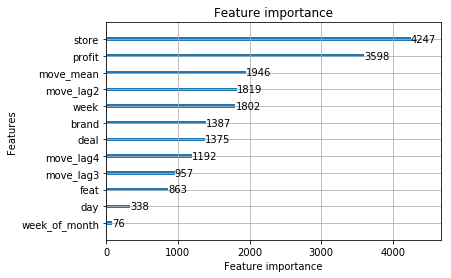

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()

      move   actual
week               
137   3164   4896.0
138   3432  10176.0
139   2642   5184.0
140   2561   5472.0
141   2842   2976.0
142   2611   4224.0
143   2382   3552.0
144   2262   3936.0
145   2346   3840.0
146   2260   5088.0
147   2267   4416.0
148   2259   3936.0
149   2473   3840.0
150   2471   9408.0
151   2294   2880.0
152   2286   4704.0
153   2441   3648.0
154   2266   4224.0
155   2334   4320.0
156   2254   3360.0
157   2399   4128.0
158   2399   3936.0
159   2276   3456.0
160   2311   5856.0
42.61786781256768


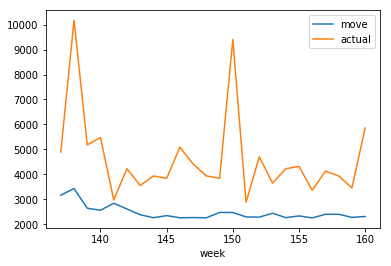

In [44]:
import random
results = pd.concat(combined_all, axis=0)

def plot_result(results, store, brand):
    subset = results[(results.store==store) & (results.brand==brand)]
    subset = subset[['week', 'move', 'actual']].set_index('week')
    #subset = subset[['week', 'move']].set_index('week')
    print(subset)
    print(evaluate(subset))
    plt.figure()
    subset.plot()
    
store = random.choice(results['store'].unique())
brand = random.choice(results['brand'].unique())
plot_result(results, store, brand)

      move   actual
week               
137   1743   2944.0
138   1734   2688.0
139   1879  13248.0
140   1901   4288.0
141   2976   3264.0
142   3032   5952.0
143   2015   2752.0
144   1952   2624.0
145   2041   1600.0
146   1942   3136.0
147   1581   4608.0
148   1530   3776.0
149   1797   4096.0
150   2086   4928.0
151   1943   2880.0
152   1990   3776.0
153   1971   2752.0
154   1916   1792.0
155   1953   4096.0
156   1944    896.0
157   2684   1856.0
158   2418   1728.0
159   1560   1792.0
160   1429   1856.0
43.23166901727819


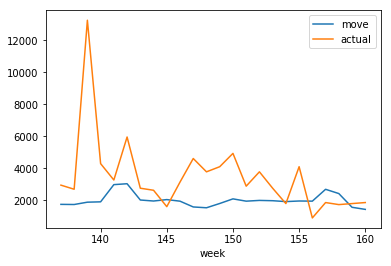

In [46]:
store = random.choice(results['store'].unique())
brand = random.choice(results['brand'].unique())
plot_result(results, store, brand)

In [45]:
results[['brand', 'store', 'week', 'move', 'actual']]

,brand,store,week,move,actual
0,1,2,137,3803,9792.0
1,1,2,138,3803,16960.0
2,2,2,137,4220,6240.0
3,2,2,138,4875,14784.0
4,3,2,137,1617,1920.0
5,3,2,138,1590,1408.0
6,4,2,137,2399,1984.0
7,4,2,138,2159,10944.0
8,5,2,137,3502,19008.0
9,5,2,138,3563,3904.0
